# JojaMart Catalogue Challenge (Notebook 1 of 2)

### Challenge description

JojaMart regularly updates its store catalogue every half year. Some products get discontinued. JojaMart wants to predict which products will be discontinued in advance, which will help it reduce inefficiencies in inventory management.

JojaMart has challenged ME to do this for them!

Using the past data on the catalogue updates provided by JojaMart's local Stardew Valley branch, how well can I predict which products they will choose to continue this time?

### Summary of my solution

In the following notebook, I develop a supervised machine learning model (Random Forest) which predicts which items JojaMart will discontinue with an **accuracy of 97%** when generalised to data in an unseen hold-out data set that was not used for model training.

### Contents

My solution is divided into 2 notebooks:

1. Exploratory Data Analysis
2. Model Selection and Training

### Packages

I will make use of the following publicly 
available free packages:

* pandas - good for big data handling
* numpy  - useful for linear algebra
* matplotlib - plotting library
* sklearn  -  good selection of supervised / unsupervised machine learning models
* seaborn - advanced plotting of pandas dataframes


### 2. Exporatory Data Analysis (EDA)

Before working on the model, it is important to first understand the data that I will be working with.

There are 2 important data files (plus a third which describes the column titles which I will not import)

I will use Pandas to load the data from the .csv files into Pandas dataframes and explore the data:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

catalogue_discontinuation = pd.read_csv("datasheet_1.csv") 
product_details = pd.read_csv("datasheet_2.csv")

#### 2.a: Check for missing data / irregularities / duplicates

In [2]:
print(catalogue_discontinuation.columns)
print(catalogue_discontinuation.info())
print(catalogue_discontinuation.shape)
print(catalogue_discontinuation.isnull().values.any())

Index(['CatEdition', 'SpringSummer', 'ProductKey', 'WeeksOut', 'Status',
       'SalePriceIncVAT', 'ForecastPerWeek', 'ActualsPerWeek',
       'DiscontinuedTF'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3625659 entries, 0 to 3625658
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   CatEdition       int64  
 1   SpringSummer     bool   
 2   ProductKey       int64  
 3   WeeksOut         int64  
 4   Status           object 
 5   SalePriceIncVAT  float64
 6   ForecastPerWeek  float64
 7   ActualsPerWeek   float64
 8   DiscontinuedTF   bool   
dtypes: bool(2), float64(3), int64(3), object(1)
memory usage: 200.5+ MB
None
(3625659, 9)
False


The catalogue_discontinuation dataframe contains 9 columns, with a range of data types (Boolean, float, etc).
There are no null values, i.e. no missing data, so that is good. 

In [3]:
print(product_details.columns)
print(product_details.info())
print(product_details.shape)


Index(['ProductKey', 'Supplier', 'HierarchyLevel1', 'HierarchyLevel2',
       'DIorDOM', 'Seasonal'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77372 entries, 0 to 77371
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ProductKey       77372 non-null  int64 
 1   Supplier         77372 non-null  int64 
 2   HierarchyLevel1  77372 non-null  int64 
 3   HierarchyLevel2  77372 non-null  int64 
 4   DIorDOM          77372 non-null  object
 5   Seasonal         77372 non-null  bool  
dtypes: bool(1), int64(4), object(1)
memory usage: 3.0+ MB
None
(77372, 6)


The product_details dataframe contains 6 columns, again with a mix of data types.
There are no null values, i.e. no missing data, so that is good.

Now I check if all the product keys in the product_details dataframe are unique:

In [4]:
# Check if all ProductKeys are unique:
print(len(set(product_details["ProductKey"])) == len(product_details["ProductKey"]))

True


Since the length of the ProductKey column is equal to the length of the set, this tells me there are **no duplicate entries**, which is good.

Now checking the number of unique products in the ProductKey columns for each dataframe:

In [5]:
n1 = len(set(catalogue_discontinuation["ProductKey"]))
n2 = len(set(product_details["ProductKey"]))

print("There are {} unique product keys in the catalogue_discontinuation dataframe.".format(n1))
print("There are {} unique product keys in the product_details dataframe.".format(n2))

There are 70227 unique product keys in the catalogue_discontinuation dataframe.
There are 77372 unique product keys in the product_details dataframe.


This is useful information to know, as I will now merge the dataframes. I note that there are ~7000 more products in the product_details table than the catalogue_discontinuation table.

I will use Pandas a merge to join the dataframes on the ProductKey identifier column.

I choose an inner join with catalogue_discontinuation as the left table. This will mean that products existing in product_details, but not in catalogue_discontinuation, will be discarded. This is acceptable, since if the product is not included in catalogue_discontinuation, it is not useful for training the model anyways.

In [6]:
df = pd.merge(catalogue_discontinuation, product_details, how="inner", on="ProductKey")
df.info()
df.shape
df.isnull().values.any()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3625659 entries, 0 to 3625658
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   CatEdition       int64  
 1   SpringSummer     bool   
 2   ProductKey       int64  
 3   WeeksOut         int64  
 4   Status           object 
 5   SalePriceIncVAT  float64
 6   ForecastPerWeek  float64
 7   ActualsPerWeek   float64
 8   DiscontinuedTF   bool   
 9   Supplier         int64  
 10  HierarchyLevel1  int64  
 11  HierarchyLevel2  int64  
 12  DIorDOM          object 
 13  Seasonal         bool   
dtypes: bool(3), float64(3), int64(6), object(2)
memory usage: 342.3+ MB


False

In the new merged dataframe, there are no null values. This is very good - it tells me that the ProductKeys column of the product_details dataframe included *all* ProductIDs used in the catalogue_discontinuation dataframe. 

This means I do not need to worry about missing data. (Note that if I did, I would have to consider strategies such as discarding rows, or data imputation). 


#### 2.b Visual Exporation

Now plot histograms of the numerical data to observe how it's distributed:

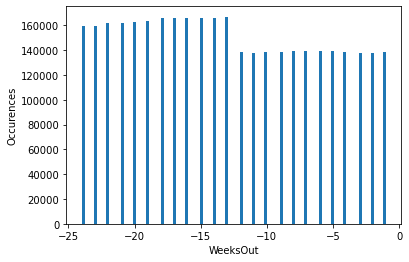

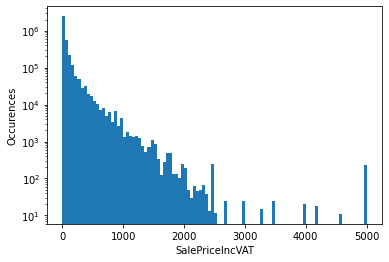

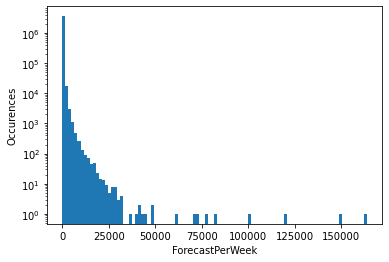

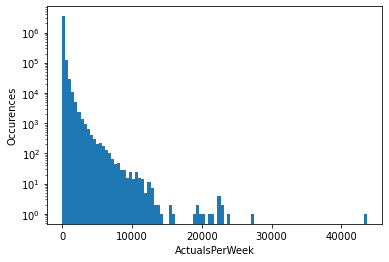

In [7]:
# Separate data into categorical and non-categorical data.
categoricals = ["SpringSummer", "Status", "DiscontinuedTF", "DIorDOM", "Seasonal", "ProductKey", "HierarchyLevel1","HierarchyLevel2"]
continuous = ["WeeksOut", "SalePriceIncVAT", "ForecastPerWeek", "ActualsPerWeek"]

for col in continuous:
    plt.hist(df[col], bins = 100)
    if col != "WeeksOut":
        plt.semilogy()
    plt.xlabel(col)
    plt.ylabel("Occurences")
    plt.show()

This is quite informative: 
* WeeksOut is in discrete timesteps as expected and they are roughly evenly distributed, which means I don't need to worry about the imbalance.
* The prices follow what looks like an exponential distribution: makes sense - there will be far fewer expensive items.
* Similarly for the sales figures. The ForecastPerWeek distribution has similar shape to the ActualsPerWeek, so it's probably worth checking for correlations.

Checking for any correlations in the data:

<AxesSubplot:>

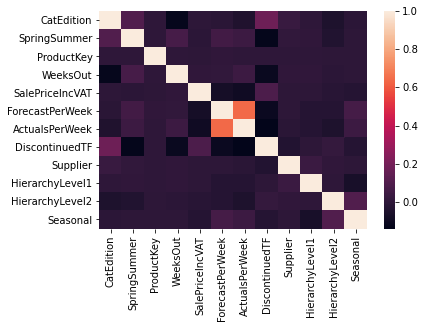

In [8]:
sns.heatmap(df.corr())

The data is largely uncorrelated, which is good. 

The main correlation is between ActualsPerWeek and ForecastPerWeek - this makes sense, as we expect our predictions to be somewhat near the data!

There is also a strong correlation between Status and DiscontinuedTF. This is expected as Status is a predictor. I expect that Status will be a highly informative feature. I don't believe it is a case of data leakage, so I think it is acceptable to use it to train the data.

### 3. Feature Transformation

I must first encode the categorical and boolean data numerically so that the model can interpret it.

I need to one-hot encode the categorical variables as binary 0 or 1. 
The column features I will transform in this way are: "SpringSummer", "Seasonal", "DiscontinuedTF", "DIorDOM" and "Status".

I will do this using pandas methods, since it makes it explicit what I am doing. (However I could use e.g. sklearn's OneHotEncoder class):

In [9]:
df["DiscontinuedTF"] = df["DiscontinuedTF"].replace([True, False], [1, 0])   # don't use inplace=True as that's bad practice
df["SpringSummer"]   = df["SpringSummer"].replace([True, False], [1, 0])     
df["Seasonal"]       = df["Seasonal"].replace([True, False], [1, 0])
df["Status"]         = df["Status"].replace(['RI', 'RO'], [1, 0])
df["DIorDOM"]        = df["DIorDOM"].replace(['DI', 'DOM'], [1, 0])

###  My expectations for which predictors will be important

Here I'll briefly discuss how I think some of the feature variables are likely to impact the prediction of "DiscontinuedTF".

* SpringSummer and Seasonal - I expect that seasonal products are very likely to predict discontinuation, since e.g. beachballs will be discontinued come Autumn.
* Similarly, I expect ProductKey could be an important predictor, since it would also encode seasonality - the model will learn which products are repeatedly discontinued.
* I expect that Status is a strong predictor of discontinuation, expecially when WeeksOut is closer to zero, as there is less likely to be a last minute change of Status. This is also suggested by the correlation matrix.
* I expect CatEdition to have little effect - neglect this

Rather than do feature selection now, I will test these beliefs later using a feature importance selection method.


### Model Selection and Training is discussed in notebook 2 in the repository.